# Project description

In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.

If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

from : https://www.kaggle.com/c/ieee-fraud-detection/overview

This is a supervised machine learning task: given a set of data with targets (in this case the isFraud) included, we want to train a model that can learn to map the features to the target.

Supervised problem: we are given both the features and the target
During training, we want the model to learn the relationship between the features and the score so we give it both the features and the answer. Then, to test how well the model has learned, we evaluate it on a testing set where it has never seen the answers!

In [0]:
FIRST_TIME = False

**Import data from Kaggle**

In [0]:
if FIRST_TIME:

  os.environ['KAGGLE_USERNAME']='#xxxxxx' 
  os.environ['KAGGLE_KEY']='#xxxxxx' 

  !kaggle competitions download -c ieee-fraud-detection -p /content/gdrive/My\ Drive/Data\ scientist\ Project/fraud\ Competition\ Kaggle # api copied from kaggle

  train_transaction = pd.read_csv('train_transaction.csv.zip', index_col='TransactionID')
  test_transaction = pd.read_csv('test_transaction.csv.zip', index_col='TransactionID')

  train_identity = pd.read_csv('train_identity.csv.zip', index_col='TransactionID')
  test_identity = pd.read_csv('test_identity.csv.zip', index_col='TransactionID')

  sample_submission = pd.read_csv('sample_submission.csv.zip', index_col='TransactionID')

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

In [0]:
PATH = "/content/gdrive/My Drive/Data scientist Project/fraud Competition Kaggle/"

**Import library**

In [0]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 4

import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

from itertools import product

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


from IPython.display import HTML
import json

import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)


In [0]:
train_transaction = pd.read_csv(PATH+'train_transaction.csv.zip', index_col='TransactionID')
test_transaction = pd.read_csv(PATH+'test_transaction.csv.zip', index_col='TransactionID')

train_identity = pd.read_csv(PATH+'train_identity.csv.zip', index_col='TransactionID')
test_identity = pd.read_csv(PATH+'test_identity.csv.zip', index_col='TransactionID')

sample_submission = pd.read_csv(PATH+'sample_submission.csv.zip', index_col='TransactionID')

In [0]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.

**Merge data**

In [0]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)


In [0]:
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

In [0]:
train.shape

(590540, 433)

In [0]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

# Data Cleaning and Formatting

**Dummies/LabelEncoder/Drop-column**
---

In [0]:
null_columns = train.columns[train.isna().all()].tolist()
col_not_relevant = []
for col in train.columns.values:
    if len(train[col].value_counts()) == 1:
        col_not_relevant.append(col)

In [0]:
#Let's check how many fraud are present in our data  
train['isFraud'].value_counts(dropna=False)

0    569877
1     20663
Name: isFraud, dtype: int64

In [0]:
#let's drop all column with more than 400000 nan values
isna = train.isnull().sum(axis=0)
cols_majority_nan = []
for col in isna.index:
  if isna[col] > 400000:
    cols_majority_nan.append(col)
train = train.drop(cols_majority_nan,axis=1)

#has to be 225 column now
print("new dataframe shape: ")
print(train.shape)

cols_no_nan = []
for col in isna.index:
  if isna[col] == 0 :
    cols_no_nan.append(col)
print("nbr of no NaN column")
#has to be 19
print(len(cols_no_nan))

new dataframe shape: 
(590540, 225)
nbr of no NaN column
19


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 225 entries, isFraud to V321
dtypes: float64(209), int64(3), object(13)
memory usage: 1.0+ GB


In [0]:
object_columns = train.select_dtypes(include=['object']).columns
object_columns = object_columns.to_list()

In [0]:
set(object_columns) & set(cols_no_nan)

{'ProductCD'}

In [0]:
train = pd.get_dummies(train, columns=["M1","M2","M3","M4","M5","M6","M7","M8","M9"],dummy_na=True)

In [0]:
train[train['card4'].isnull()]['card6'].value_counts(dropna=False);

In [0]:
train = train[train['card4'].notnull()]
train = train[train['card6'].notnull()]

In [0]:
train.shape

(588957, 244)

In [0]:
train = pd.get_dummies(train, columns=["card4","card6"])
#get dummies for product_CD ( 5 categories)
train = pd.get_dummies(train, columns=["ProductCD"])
#P_emaildomain has an high number of NaN , so to encode with label encoder we need to transform them in str type ( in one categorie)
train.loc[train['P_emaildomain'].isnull(), 'P_emaildomain'] = 'nan'
le_cols = []
for c in ["P_emaildomain"]:
            le = LabelEncoder()
            le.fit(train[c])
            le_cols.append(le)
            train[c] = le.transform(train[c])


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588957 entries, 2987000 to 3577539
Columns: 254 entries, isFraud to ProductCD_W
dtypes: float64(209), int64(4), uint8(41)
memory usage: 984.6 MB


**Feature engeniering**
---

**Date feature from TransactionDT column**

---

In [0]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))


train['dow'] = train['TransactionDT'].dt.dayofweek
train['hour'] = train['TransactionDT'].dt.hour


In [0]:
train = train.drop(['TransactionDT'],axis=1)

In [0]:
train.shape

(588957, 255)

In [0]:
train.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,dow,hour
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,5,0
2987001,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,16,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,5,0
2987002,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,36,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.

In [0]:
train['id'] = range(1, len(train) + 1)

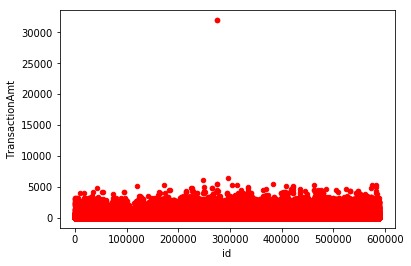

In [0]:
train.plot(kind='scatter', x='id', y='TransactionAmt', color='r')    

In [0]:
train[train['TransactionAmt'] > 10000]

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,dow,hour,id
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3261336,0,31937.391,16075,514.0,150.0,102.0,205.0,87.0,27.0,54,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1422.3900,1422.3900,1422.3900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,1422.39,1422.39,1422.39,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,3,23,274322
3261339,0,31937.391,16075,514.0,150.0,102.0,205.0,87.0,27.0,54,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,31937.3906,31937.3906,31937.3906,0.0,0.0,0.0,31937.3906,31937.3906,31937.3906,0.0,0.0,0.0,2.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,33359.7812,33359.7812,33359.7812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31937.3906,31937.3906,31937.3906,1422.39,1422.39,1422.39,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,3,23,274325


In [0]:
train = train.drop(['id'],axis=1)

**correlated feature**

---

In [0]:
corr_matrix = train.corr().abs()

In [0]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.98
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]

# Find index of feature columns with correlation less than 0.03 with fraud feature
corr_with_fraud_less = corr_matrix.iloc[:]['isFraud'] < 0.00

#drop only them (i.e duplicate row that have little (almost 0 ) correlation with fraud column)
to_drop_real = set(corr_with_fraud_less[corr_with_fraud_less].index) & set(to_drop)

train = train.drop(train[to_drop_real], axis=1)

#has to be 234
train.shape

(588957, 255)

In [0]:
# corr_with_fraud_high = corr_matrix.iloc[:]['isFraud'] > 0.1
# corr_with_fraud_high[corr_with_fraud_high]

In [0]:
df_describe = train.describe()
df_describe = df_describe.drop(['isFraud'],axis=1)
df_describe

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,dow,hour
count,588957.0000,588957.0000,581596.0000,588957.0000,586271.0000,523440.000,523440.0000,237938.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,587689.0000,308871.0000,326699.0000,420272.0000,279822.0000,512953.0000,310034.0000,499873.0000,310034.0000,310034.0000,310034.0000,310034.0000,310034.0000,310034.0000,310034.0000,310034.0000,310034.0000,310034.0000,310034.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,512902.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,420225.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,511878.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,499822.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588643.0000,588946.0000,588946.000,587689.0000,587689.0000,587689.0000,588946.0000,588946.0000,588946.0000,588946.0000,587689.0000,587689.0000,588946.0000,588946.0000,588946.0000,588946.0000,588946.0000,588946.0000,587689.0000,588946.0000,588946.0000,588946.0000,587689.0000,587689.0000,588946.0000,588946.0000,588946.0000,588946.0000,588946.0000,588946.0000,588946.0000,588946.0000,588946.0000,588946.0000,588946.0000,587689.0000,587689.0000,587689.0000,588946.0000,588946.0000,588946.0000,588946.0000,588946.0000,588946.0000,5.8896e+05,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.0000,588957.000

**Reduce memory usage**

---



In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
train = reduce_mem_usage(train)

Mem. usage decreased to 285.89 Mb (71.1% reduction)


**Card/Amount feature**

---

In [0]:
train.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,dow,hour
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,5,0
2987001,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,16,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,5,0
2987002,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,36,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.

In [0]:
#delete 2 outliers transaction
train = train[train['TransactionAmt'] < 10000]

In [0]:
transaction_amt_mean = train.mean(axis = 0, skipna = True)['TransactionAmt']
transaction_amt_mean

134.71866

In [0]:
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

train['card2_count_full'] = train['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))

train['card3_count_full'] = train['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))

train['card5_count_full'] = train['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))

train['addr1_count_full'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))

train['addr2_count_full'] = train['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))


In [0]:
train.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,dow,hour,card1_count_full,card2_count_full,card3_count_full,card5_count_full,addr1_count_full,addr2_count_full
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,5,0,56,16015,956834,309,42963,955026
2987001,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,16,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,5,0,1333,5593,956834,49489,76777,955026
2987002,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,36,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1

In [0]:
#difference between the transaction amount mean and this specific transaction
train['std_transaction_amount'] = abs(train['TransactionAmt'] - transaction_amt_mean)

In [0]:
train.shape

(588955, 262)

In [0]:
#average of all transaction done by this card
train['card1_mean_amount'] = train['card1'].map(train.groupby(['card1'])['TransactionAmt'].mean())

In [0]:
train[train['card1'] ==  3209]

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,dow,hour,card1_count_full,card2_count_full,card3_count_full,card5_count_full,addr1_count_full,addr2_count_full,std_transaction_amount,card1_mean_amount
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3320978,0,61.3125,3209,134.0,119.0,102.0,NaN,NaN,NaN,16,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,2,817,1091,49489,131126,131126,73.4375,61.3125
3320985,0,61.3125,3209,134.0,119.0,102.0,NaN,NaN,NaN,16,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,61.3263,61.3263,61.3263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.3263,61.3263,61.3263,0.0,0.0,0.0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,2,817,1091,49489,131126,131126,73.4375,61.3125


In [0]:
train.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,dow,hour,card1_count_full,card2_count_full,card3_count_full,card5_count_full,addr1_count_full,addr2_count_full,std_transaction_amount,card1_mean_amount
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,32,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,5,0,56,16015,956834,309,42963,955026,66.25,352.0000
2987001,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,16,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,5,0,1333,5593,956834,49489,76777,955026,105.75,235.0000
2987002,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,36,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0

In [0]:
#train['card1'].map(train.groupby(['card1'])['TransactionAmt'].mean())

In [0]:
#train['card1'].value_counts().tail(5000)

In [0]:
#train.groupby(['card1'])['TransactionAmt'].mean()[13712]

**Imbalanced class**
----



In [0]:
train['isFraud'].value_counts()

0    568333
1     20622
Name: isFraud, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score


df_train, df_test = split(train, test_size=0.3, random_state=14)

In [0]:
df_train.shape

(412268, 263)

In [0]:
df_train['isFraud'].value_counts()

0    397758
1     14510
Name: isFraud, dtype: int64

In [0]:
df_test.shape

(176687, 263)

In [0]:
df_test['isFraud'].value_counts()

0    170575
1      6112
Name: isFraud, dtype: int64

In [0]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df_train[df_train.isFraud==0]
df_minority = df_train[df_train.isFraud==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=70000,     # to match minority class  
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.isFraud.value_counts()


0    70000
1    14510
Name: isFraud, dtype: int64

**outliers from the sample ( because of time duration) ( not to run)**
---


In [0]:
outliers = []
j=0
for index, row in df_train.iterrows():
  j = j + 1
  if j % 50000 == 0 :
    print("another 50000")
  i = 0 
  for col in df_train.columns[1:-41]:
    mean = df_describe.loc['mean'][col]
    std = df_describe.loc['std'][col]
    outliers_threshold_high = mean + 6 * std
    outliers_threshold_low = mean - 6 * std
    if(row[col] > outliers_threshold_high or row[col] < outliers_threshold_low):
      i = i + 1
      if i > 5 :
        outliers.append(index)
        break;

In [0]:
j

In [0]:
with open('outliersfile.txt', 'w') as filehandle:
   for listitem in outliers:
       filehandle.write('%s\n' % listitem)

In [0]:
from google.colab import files

files.download('outliersfile.txt')

In [0]:
df_train['id'] = range(1, len(df_train) + 1)

In [0]:
nrow = 3
ncol = 3
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16,12))

l = ['V111','V112','V113','V114','V115','V116','V117','V118','V119']
for i in range(nrow):
  for j in range(ncol):
    df_train.plot(kind='scatter', x='id', y=l.pop(), color='b',ax=axes[i,j])    


In [0]:
nrow = 2
ncol = 3
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16,12))

l = ['card1','card2','card3','card5','addr1','addr2']
for i in range(nrow):
  for j in range(ncol):
    df_train.plot(kind='scatter', x='id', y=l.pop(), color='b',ax=axes[i,j])    

In [0]:
nrow = 2
ncol = 3
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16,12))


l = ['C1','C2','C3','C4','C5','C7']#,'TransactionAmt','V118','V119']
for i in range(nrow):
  for j in range(ncol):
    df_train.plot(kind='scatter', x='id', y=l.pop(), color='r',ax=axes[i,j])    



In [0]:
df_train.head()

In [0]:
df_outliers = df_train.ix[outliers]
df_outliers['isFraud'].value_counts()

Too much outliers , not remove them keep the data as is 

**Model**
---

In [0]:
#For better result take from df_train and NOT from df_downsampled
X_train = df_train.drop('isFraud', axis=1)
y_train = df_train['isFraud']
X_test = df_test.drop('isFraud', axis=1)
y_test = df_test['isFraud']

In [0]:
def classification_results(y, y_pred, name='', classes=['no', 'yes'], add_rep=False):
    acc = accuracy_score(y, y_pred)
                        
    cm = pd.DataFrame(confusion_matrix(y, y_pred), 
                      index=classes, 
                      columns=classes)

    print(name + ' accuracy: ', round(acc,4))
    print()
    print(cm)
    print()
    if (add_rep):
        print(name + ' Classification report: ')
        print(classification_report(y, y_pred))

**GridSearchCV**

In [0]:
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.08], #so called `eta` value
              'max_depth': [15],
              'min_child_weight': [1],
              'subsample': [0.7],
              'colsample_bytree': [1],
              'n_estimators': [400], #number of trees, change it to 1000 for better results
              }

In [0]:
clf = GridSearchCV(xgb.XGBClassifier(), parameters, n_jobs=5, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=10, refit=True)

In [0]:
clf.fit(X_train, y_train)


In [0]:
def printResultGridSearch(clf):
  print(clf.best_params_)
  print(clf.best_score_)
  print(clf.cv_results_)

In [0]:
printResultGridSearch(clf)

In [0]:
clf.best_params_

In [0]:
classification_results(y_train, clf.predict(X_train), name='XGBClassifier (gridSearch) train')

In [0]:
classification_results(y_test, clf.predict(X_test), name='XGBClassifier (gridSearch) test')

In [0]:
scores = clf.predict_proba(X_test)
print('ROC Area Test = '+str(roc_auc_score(y_test, scores[:,1])))

In [0]:
#fpr, tpr, thresholds = roc_curve(y_train, scores[:,1])
#plt.plot(fpr, tpr)
#plt.title('ROC')
#plt.xlabel('FPR (False Positive Rate = 1-specificity)')
#plt.ylabel('TPR (True Positive Rate = sensitivity)')
#plt.title('ROC = '+str(roc_auc_score(y_train, scores[:,1])));

**XGB model**

In [0]:
xgb_model = xgb.XGBClassifier(max_depth=15,
                                    n_estimators=400,
                                    learning_rate=0.08, 
                                    subsample=1,tree_method='gpu_hist',verbose=1)


xgb_model.fit(X_train.values, y_train.values, verbose=1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.08, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbose=1,
              verbosity=1)

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

In [0]:
classification_results(y_train, xgb_model.predict(X_train.values), name='XGBClassifier train')

XGBClassifier train accuracy:  0.999

         no    yes
no   397756      2
yes     397  14113



In [0]:
classification_results(y_test, xgb_model.predict(X_test.values), name='XGBClassifier test')

XGBClassifier test accuracy:  0.9857

         no   yes
no   170374   201
yes    2326  3786



In [0]:
scores = xgb_model.predict_proba(X_test.values)
print('ROC Area Test = '+str(roc_auc_score(y_test, scores[:,1])))

ROC Area Test = 0.9702497802512752


In [0]:
X_train.columns[258]

'addr1_count_full'

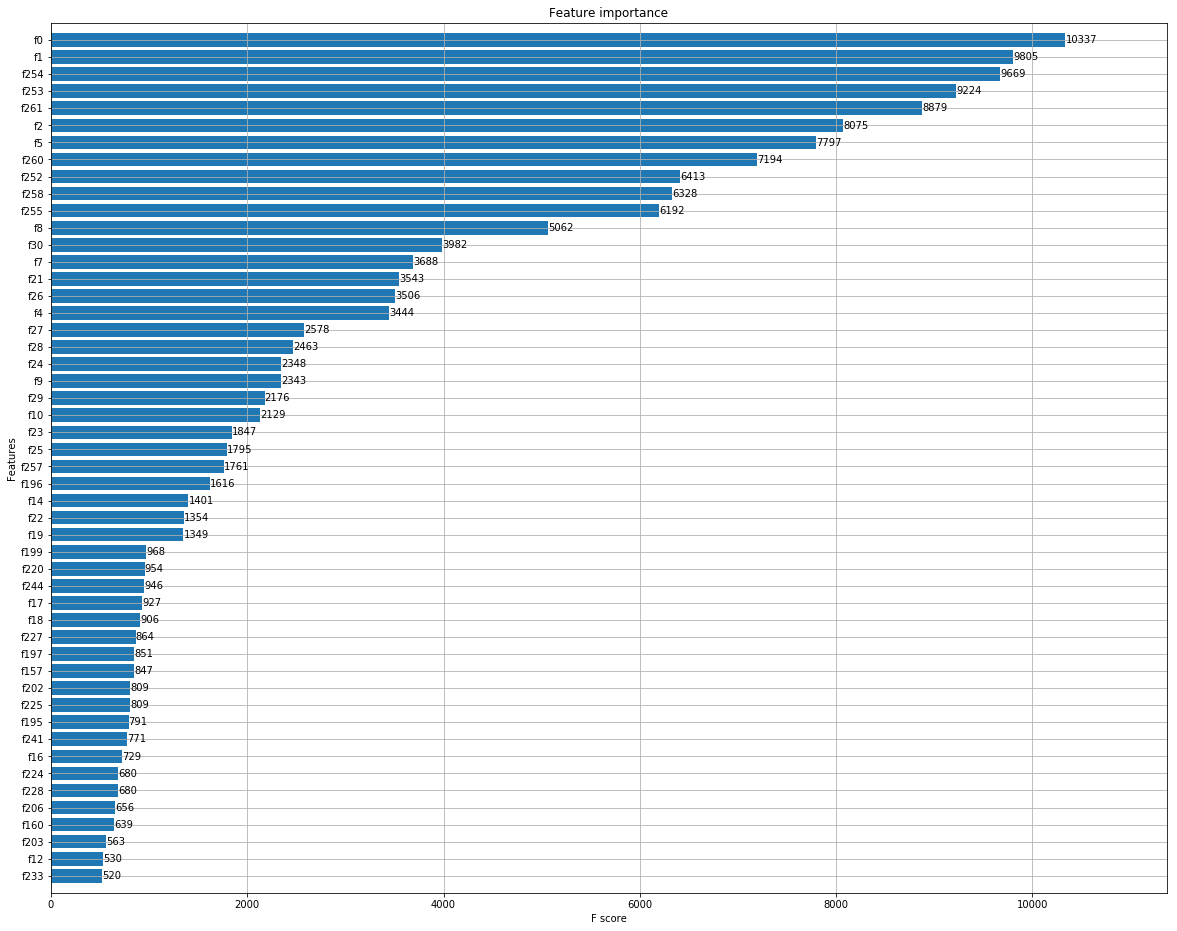

In [0]:
fig, ax = plt.subplots(1,1,figsize=(20,16))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [0]:
X_train.shape

(84510, 262)

In [0]:
feature_importance = xgb_model.feature_importances_

In [0]:
results_importance = []
for i in range(X_train.shape[1]):
  results_importance.append((feature_importance[i],X_train.columns[i]))

In [0]:
results_importance

Re run the XGboost model with all the row , do not downsampling ! 
In Google collab put GPU in runtime --> change runtime session and run with all data it will take just few seconds and not hours like previously ...

**Submission**
---

In [0]:
test.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.00,47.95,0.00,0.00,47.95,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [0]:
test = test.drop(cols_majority_nan,axis=1);
test = pd.get_dummies(test, columns=["M1","M2","M3","M4","M5","M6","M7","M8","M9"],dummy_na=True)
test = pd.get_dummies(test, columns=["card4","card6"])
test['card6_debit or credit']=0
test = pd.get_dummies(test, columns=["ProductCD"])
test.loc[test['P_emaildomain'].isnull(), 'P_emaildomain'] = 'nan'
test.loc[test['P_emaildomain'] == 'scranton.edu' , 'P_emaildomain'] = 'nan'
test['P_emaildomain'] = le_cols[0].transform(test['P_emaildomain'])
test = test.drop(test[to_drop_real], axis=1)

In [0]:
#change label encoder for test + train

In [0]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

# test['year'] = test['TransactionDT'].dt.year
# test['month'] = test['TransactionDT'].dt.month
test['dow'] = test['TransactionDT'].dt.dayofweek
test['hour'] = test['TransactionDT'].dt.hour
# test['day'] = test['TransactionDT'].dt.day
# test = test.drop(['year'],axis=1)
test = test.drop(['TransactionDT'],axis=1)

In [0]:
test = reduce_mem_usage(test)

Mem. usage decreased to 249.34 Mb (70.7% reduction)


In [0]:
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

test['card2_count_full'] = test['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))

test['card3_count_full'] = test['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))

test['card5_count_full'] = test['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))

test['addr1_count_full'] = test['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))

test['addr2_count_full'] = test['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))

In [0]:
test['std_transaction_amount'] = abs(test['TransactionAmt'] - transaction_amt_mean)

In [0]:
test['card1_mean_amount'] = test['card1'].map(test.groupby(['card1'])['TransactionAmt'].mean())

In [0]:
test.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,dow,hour,card1_count_full,card2_count_full,card3_count_full,card5_count_full,addr1_count_full,addr2_count_full,std_transaction_amount,card1_mean_amount
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3663549,31.9531,10409,111.0,150.0,226.0,170.0,87.0,1.0,16,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,418.0,203.0,409.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.00,47.95,0.00,0.0000,47.95,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,47.95,0.00,0.0000,47.95,0.0000,0.00,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,150,82537,956834,553532,3804,955026,102.8125,94.1250
3663550,49.0000,4272,111.0,150.0,226.0,299.0,87.0,4.0,2,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,231.0,634.0,634.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.00,280.00,77.00,0.0000,280.00,77.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,280.00,77.00,0.0000,280.00,0.0000,77.00,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,2070,82537,956834,553532,84922,955026,85.7500,146.8750
3663551,171.0000,4476,574.0,150.0,226.0,472.0,87.0,2636.0,19,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,136.0,136.0,97.0,1.0,1.0,1.0

In [0]:
test.shape

(506691, 262)

In [0]:
train.shape

(588955, 263)

In [0]:
y_preds = xgb_model.predict_proba(test.values)[:,1]

In [0]:
y_preds

array([0.00019738, 0.00025484, 0.00020625, ..., 0.00156891, 0.00312071,
       0.00286576], dtype=float32)

In [0]:
sample_submission["isFraud"] = y_preds
sample_submission.to_csv("submit.csv")
sample_submission.head()

,isFraud
TransactionID,
3663549,1.9738e-04
3663550,2.5484e-04
3663551,2.0625e-04
3663552,8.4204e-05
3663553,1.3027e-04


In [0]:
from google.colab import files

files.download('submit.csv')